In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numba 

In [2]:
import src.solutions as solutions
import src.visualizations as visualizations

## Part 1

first draft on assignment 1a, wrote it as an iterative scheme over time and space, saving the two previous time values for the computation of the next time point

The discretized wave equation becomes (with functions from solutions): 

time_approx_1a(deltat, time, func, x) = c^2* spat_approx_1a(deltax, time, func, x, L)

you can rewrite this to get the values of the next time point

In [3]:
L = 1
N = 100
c=2
time = 0

deltax = L/N
deltat = L/N
xs = np.arange(0, L, deltax)

#saving the solutions
sols_prev = np.zeros(len(xs))
sols = np.zeros(len(xs))
sols_next = np.zeros(len(xs))

#the full function 
for i in range(1000):
    for j,x in enumerate(xs):
        if j == 0: 
            sols_next[j]= 0
        elif j == len(xs) -1:
            sols_next[j] = 0
        else:
            sols_next[j] = np.power(deltat, 2) * np.power(c, 2) * solutions.spat_approx_1a(deltax, time, (sols[j-1], sols[j], sols[j+1]), x, L) + 2*sols[j] - sols_prev[j]

    sols_prev = sols_next.copy()
    sols = sols_next.copy()
    

### B

Euler's method 

f_x+1 = f_x + h * f'_x

(c*delta t)/delta x < 1 for stable computation 
looking at this method, you can derive that in the first two time-points, the function follows the exact same curve as the derivative (f'_x) is 0

In [4]:
#choose out of options 1, 2 or 3
overall_solutions, xs = solutions.one_b(3)

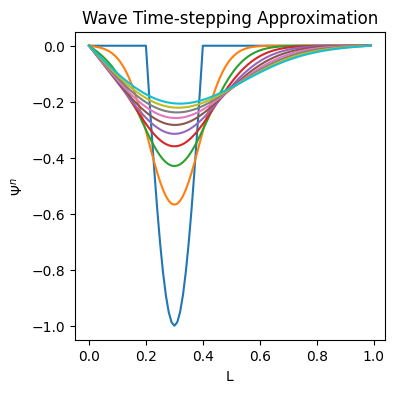

In [5]:
visualizations.visualization_1b(overall_solutions, xs)